In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch.nn.functional as F
from sklearn.manifold import TSNE
import os

# Set device
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: mps


In [2]:
# Define transformations: Center crop to square, resize to 64x64, normalize to [0,1]
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Crop to square from original 178x218
    transforms.Resize(64),
    transforms.ToTensor(),
])

# Download and load CelebA dataset (train split)
dataset = datasets.CelebA(root='../../data', split='train', download=False, transform=transform)

# Take a subset of 80,000 images
subset_indices = list(range(80000))
subset_dataset = Subset(dataset, subset_indices)

# DataLoader
batch_size = 128
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f'Dataset size: {len(subset_dataset)}')

Dataset size: 80000


In [3]:
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (256, 4, 4)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Sigmoid()  # Output in [0,1]
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [4]:
def loss_function(recon_x, x, mu, logvar):
    """
    Calculates the VAE loss.
    """
    # 1. Reconstruction Loss (how well the model reconstructs the input)
    # Using Binary Cross Entropy, summed over all pixels
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # 2. KL Divergence (a measure of how much the learned distribution differs from the prior)
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # The total loss is the sum of both
    total_loss = BCE + KLD

    return total_loss, BCE, KLD

In [38]:
# Hyperparameters
latent_dim = 128
epochs = 50  # Adjust as needed; may take time on free Colab
lr = 1e-3

# Initialize model and optimizer
model = VAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

# Training
recon_losses = []
bce_losses = []
kld_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_bce = 0.0
    train_kld = 0.0
    for batch_idx, (data, _) in enumerate(dataloader):  # Ignore labels
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_bce += bce.item()
        train_kld += kld.item()

    avg_loss = train_loss / len(dataloader.dataset)
    avg_bce = train_bce / len(dataloader.dataset)
    avg_kld = train_kld / len(dataloader.dataset)
    recon_losses.append(avg_loss)
    bce_losses.append(avg_bce)
    kld_losses.append(avg_kld)
    print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}')

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint_path = f'checkpoints/vae_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), checkpoint_path)
        print(f'Checkpoint saved: {checkpoint_path}')

    # Visualize reconstructions every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            # Take first 8 images from the last batch
            num_recon = min(8, data.size(0))
            recon_batch, _, _ = model(data[:num_recon])
            recon_batch = recon_batch.cpu()
            data = data.cpu()

            # Plot original and reconstructed images
            fig, axes = plt.subplots(2, num_recon, figsize=(num_recon*2, 4))
            for i in range(num_recon):
                # Original
                axes[0, i].imshow(data[i].permute(1, 2, 0).numpy())
                axes[0, i].axis('off')
                if i == 0:
                    axes[0, i].set_title('Original')
                # Reconstructed
                axes[1, i].imshow(recon_batch[i].permute(1, 2, 0).numpy())
                axes[1, i].axis('off')
                if i == 0:
                    axes[1, i].set_title('Reconstructed')
            plt.suptitle(f'Reconstructions at Epoch {epoch+1}')
            plt.show()
        model.train()

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), recon_losses, label='Total Loss', marker='o')
plt.plot(range(1, epochs+1), bce_losses, label='BCE Loss', marker='s')
plt.plot(range(1, epochs+1), kld_losses, label='KLD Loss', marker='^')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating due to uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x14148a5c0>
Traceback (most recent call last):
  File "/Users/zainali/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zainali/Library/Python/3.13/lib/python/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/popen_fork.py", line 41, in wait
    if not wait([self.sentinel], timeout):
  File "/Library/Frameworks/Pyth

: 

In [5]:
# Load a saved checkpoint (change the path as needed)
checkpoint_path = 'checkpoints/vae_epoch_20.pth'  # Example
latent_dim = 128
model = VAE(latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print('Model loaded for evaluation.')

Model loaded for evaluation.


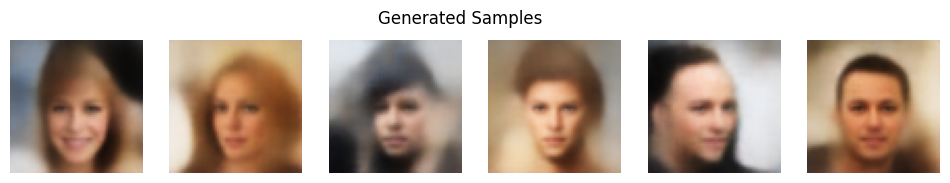

In [19]:
# Generate samples
num_samples = 6
with torch.no_grad():
    z = torch.randn(num_samples, latent_dim).to(device)
    generated = model.decode(z).cpu()

# Display
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    img = generated[i].permute(1, 2, 0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
plt.suptitle('Generated Samples')
plt.show()

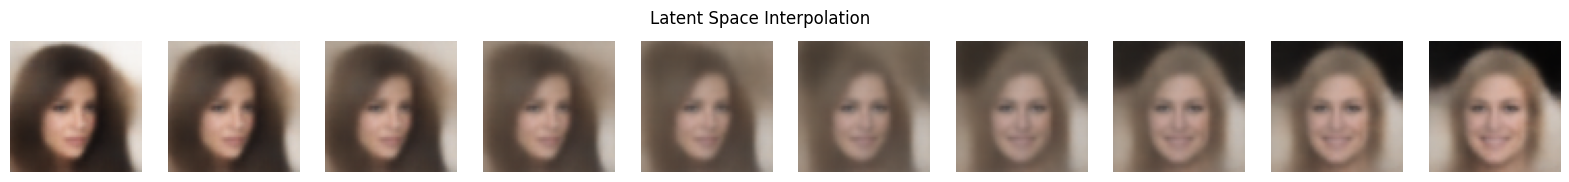

In [35]:
# Get two random images from dataset
data_iter = iter(dataloader)
batch1, _ = next(data_iter)
batch2, _ = next(data_iter)
img1 = batch1[0].unsqueeze(0).to(device)  # First image
img2 = batch2[0].unsqueeze(0).to(device)  # Second image

# Encode to latents
with torch.no_grad():
    mu1, _ = model.encode(img1)
    mu2, _ = model.encode(img2)

# Interpolate
num_steps = 10
interps = []
for alpha in np.linspace(0, 1, num_steps):
    z_interp = (1 - alpha) * mu1 + alpha * mu2
    recon_interp = model.decode(z_interp).cpu().squeeze().detach().permute(1, 2, 0).numpy()
    interps.append(recon_interp)

# Display
fig, axes = plt.subplots(1, num_steps, figsize=(20, 2))
for i in range(num_steps):
    axes[i].imshow(interps[i])
    axes[i].axis('off')
plt.suptitle('Latent Space Interpolation')
plt.show()

In [36]:
# Collect mean latents (mu) from a subset of data (e.g., 10,000 for speed)
num_samples_for_analysis = 10000
latents = []
labels = []  # Optional: collect attributes if needed

with torch.no_grad():
    count = 0
    for data, attr in dataloader:
        data = data.to(device)
        mu, _ = model.encode(data)
        latents.append(mu.cpu().numpy())
        labels.append(attr.numpy())  # CelebA has attributes
        count += data.size(0)
        if count >= num_samples_for_analysis:
            break

latents = np.concatenate(latents, axis=0)[:num_samples_for_analysis]
labels = np.concatenate(labels, axis=0)[:num_samples_for_analysis]  # Example: use for coloring points

print(f'Collected {latents.shape[0]} latents.')

Collected 10000 latents.


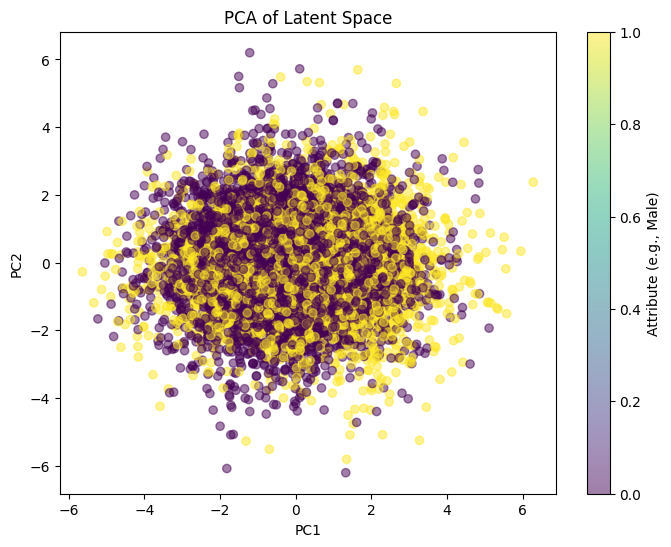

In [37]:
# PCA to 2D
pca = PCA(n_components=2)
pca_latents = pca.fit_transform(latents)

# Plot (color by an attribute, e.g., index 20 is 'Male' in CelebA attrs)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_latents[:, 0], pca_latents[:, 1], c=labels[:, 20], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Attribute (e.g., Male)')
plt.title('PCA of Latent Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

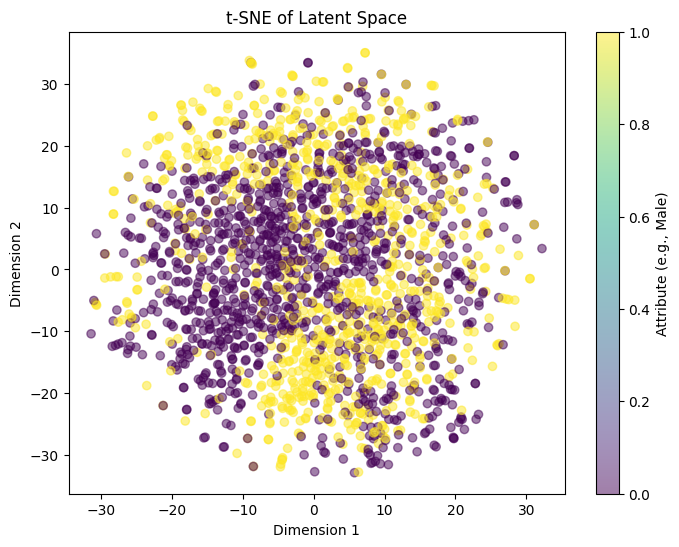

In [38]:
# t-SNE to 2D (use smaller subset for speed, as t-SNE is O(n^2))
tsne_subset_size = 2000  # Adjust based on memory/time
tsne = TSNE(n_components=2, random_state=42)
tsne_latents = tsne.fit_transform(latents[:tsne_subset_size])

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_latents[:, 0], tsne_latents[:, 1], c=labels[:tsne_subset_size, 20], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Attribute (e.g., Male)')
plt.title('t-SNE of Latent Space')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [40]:
import os
from google.colab import files

# Create the zip file
zip_filename = 'vae_data_checkpoints.zip'
os.system(f'zip -r {zip_filename} checkpoints/')

# Download the zip file
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Reconstruction MSE (sum) per image: [225.30392456054688, 161.7106170654297, 161.46792602539062, 143.6336212158203, 353.8966979980469]
Average Reconstruction MSE: 209.2025573730469


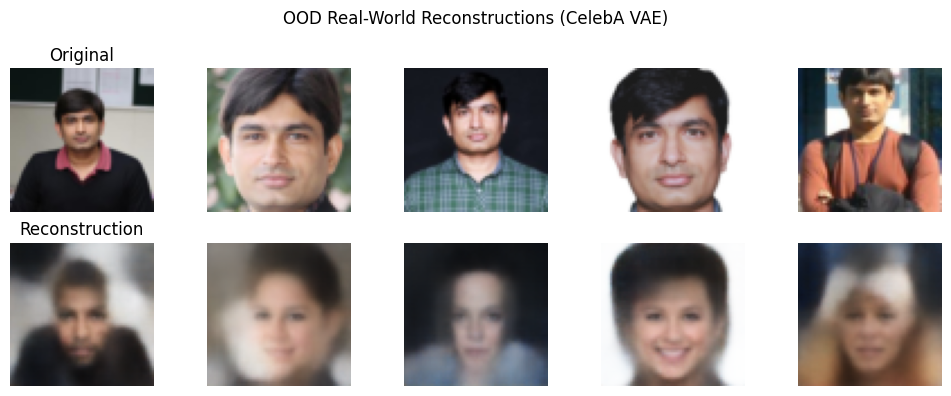

In [37]:
# OOD Evaluation: reconstruct real-world images with the CelebA VAE
import os
from pathlib import Path
from PIL import Image
import glob
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

# Ensure device
try:
    device
except NameError:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Locate OOD images folder relative to this notebook
nb_dir = Path.cwd()
proj_root = (nb_dir / '..' / '..').resolve()
ood_dir = (proj_root / 'OOD_real_world')
if not ood_dir.exists():
    # Fallbacks
    for cand in [nb_dir / '../OOD_real_world', nb_dir / 'OOD_real_world']:
        cand = cand.resolve()
        if cand.exists():
            ood_dir = cand
            break
if not ood_dir.exists():
    raise FileNotFoundError('Could not find OOD_real_world folder relative to this notebook.')

# Collect a small set of images
extensions = ('*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG')
image_paths = []
for ext in extensions:
    image_paths.extend(sorted(glob.glob(str(ood_dir / ext))))

if len(image_paths) == 0:
    raise RuntimeError(f'No images found in {ood_dir}')

# Use up to N images for a clean visualization
N = min(8, len(image_paths))
image_paths = image_paths[:N]

# Preprocess to match training input (64x64 RGB in [0,1])
preprocess = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),  # [0,1]
])

# Prepare batch
tensors = []
orig_vis = []
for path in image_paths:
    img = Image.open(path).convert('RGB')
    vis = preprocess(img)
    tensors.append(vis.unsqueeze(0))
    orig_vis.append(vis.permute(1, 2, 0).numpy())

x_batch = torch.cat(tensors, dim=0).to(device)

# Ensure model is available; if not, try to load from checkpoints
try:
    model
    _ = model.decode  # basic check
except Exception:
    # Define VAE class must be present (run earlier cells) — otherwise raise a helpful error
    try:
        VAE
    except NameError:
        raise RuntimeError('VAE class is not defined in this kernel. Please run the model definition cell above and retry.')

    try:
        latent_dim
    except NameError:
        latent_dim = 128

    # Search for checkpoints in common locations
    candidate_dirs = [
        nb_dir / 'checkpoints',
        proj_root / 'VAEs' / 'VAE Celeba' / 'checkpoints_celeba_vae_finetune',
        proj_root / 'VAEs' / 'VAE Celeba' / 'pretrained_celeba_vae',
    ]
    ckpt = None
    for d in candidate_dirs:
        d = d.resolve()
        if d.exists() and d.is_dir():
            # prefer highest epoch if pattern matches; else first .pth
            epoch_ckpts = []
            for f in d.glob('vae_epoch_*.pth'):
                try:
                    ep = int(f.stem.split('_')[-1])
                    epoch_ckpts.append((ep, f))
                except Exception:
                    pass
            if epoch_ckpts:
                epoch_ckpts.sort()
                ckpt = str(epoch_ckpts[-1][1])
                break
            # generic .pth files
            pths = list(d.glob('*.pth'))
            if pths:
                ckpt = str(pths[0])
                break
    if ckpt is None:
        raise RuntimeError('VAE model not found in current kernel and no checkpoints discovered in expected folders.')

    model = VAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

# Reconstruct
model.eval()
with torch.no_grad():
    recon_batch, _, _ = model(x_batch)
recon_np = recon_batch.cpu().permute(0, 2, 3, 1).numpy()  # (N, H, W, C), in [0,1]

# Compute and print reconstruction loss (MSE) per image and average
mse_per_image = [F.mse_loss(recon_batch[i], x_batch[i], reduction='sum').item() for i in range(x_batch.size(0))]
avg_mse = float(sum(mse_per_image) / len(mse_per_image))
print('Reconstruction MSE (sum) per image:', mse_per_image)
print('Average Reconstruction MSE:', avg_mse)

# Visualize side-by-side
cols = N
fig, axes = plt.subplots(2, cols, figsize=(2*cols, 4))
for i in range(cols):
    axes[0, i].imshow(orig_vis[i])
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_title('Original')
    axes[1, i].imshow(recon_np[i])
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_title('Reconstruction')
plt.suptitle('OOD Real-World Reconstructions (CelebA VAE)', y=0.98)
plt.tight_layout()
plt.savefig('ood_reconstructions.png', dpi=150)
plt.show()

In [10]:
# VAE Evaluation Metrics: FID, KID, SSIM, Per-Pixel MSE
# Compute metrics between reconstructed and real CelebA images.

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy import linalg
from sklearn.metrics.pairwise import polynomial_kernel
import torchvision.models as models
import torchvision.transforms.functional as TF

# Install scikit-image if not available
try:
    from skimage.metrics import structural_similarity as ssim
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "scikit-image"])
    from skimage.metrics import structural_similarity as ssim

# Load CelebA test data (same transform as training)
data_root = os.path.join(os.getcwd(), '../../data')
celeba_transform = transforms.Compose([
    transforms.CenterCrop(178),
    transforms.Resize(64),
    transforms.ToTensor(),  # [0,1]
])
celeba_dataset = datasets.CelebA(root=data_root, split='test', download=False, transform=celeba_transform)
celeba_loader = DataLoader(celeba_dataset, batch_size=64, shuffle=False, num_workers=2)

# Get a batch of real images
real_batch, _ = next(iter(celeba_loader))
real_batch = real_batch.to(device)

# Ensure model is loaded (reuse from OOD cell logic if needed)
try:
    model
    model.eval()
except NameError:
    # Load from checkpoint as in OOD cell
    try:
        VAE
    except NameError:
        raise RuntimeError('VAE class not defined. Run the model definition cell.')

    latent_dim = 128
    candidate_dirs = [
        Path.cwd() / 'checkpoints',
        Path.cwd().parent.parent / 'VAEs' / 'VAE Celeba' / 'checkpoints_celeba_vae_finetune',
        Path.cwd().parent.parent / 'VAEs' / 'VAE Celeba' / 'pretrained_celeba_vae',
    ]
    ckpt = None
    for d in candidate_dirs:
        d = d.resolve()
        if d.exists():
            epoch_ckpts = [f for f in d.glob('vae_epoch_*.pth') if f.is_file()]
            if epoch_ckpts:
                epoch_ckpts.sort(key=lambda x: int(x.stem.split('_')[-1]))
                ckpt = str(epoch_ckpts[-1])
                break
            pths = list(d.glob('*.pth'))
            if pths:
                ckpt = str(pths[0])
                break
    if ckpt is None:
        raise RuntimeError('No VAE checkpoint found.')

    model = VAE(latent_dim=latent_dim).to(device)
    model.load_state_dict(torch.load(ckpt, map_location=device))
    model.eval()

# Reconstruct
with torch.no_grad():
    recon_batch, _, _ = model(real_batch)

# Both real and recon are in [0,1]
# Per-pixel MSE (reconstruction loss)
pixel_mse = F.mse_loss(recon_batch, real_batch).item()
print(f"Per-pixel MSE: {pixel_mse:.6f}")

# SSIM (average over batch)
ssim_scores = []
for i in range(real_batch.size(0)):
    real_img = real_batch[i].permute(1,2,0).cpu().numpy()  # [H,W,C]
    recon_img = recon_batch[i].permute(1,2,0).cpu().numpy()
    score = ssim(recon_img, real_img, channel_axis=-1, data_range=1.0, win_size=11)
    ssim_scores.append(score)
avg_ssim = np.mean(ssim_scores)
print(f"Average SSIM: {avg_ssim:.6f}")

# FID and KID require Inception features
inception = models.inception_v3(pretrained=True, transform_input=False).to(device)
inception.eval()
inception.fc = torch.nn.Identity()  # Remove classifier

def get_inception_features(images):
    # Resize to 299x299 for Inception
    resized = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    with torch.no_grad():
        features = inception(resized)
    return features.cpu().numpy()

real_features = get_inception_features(real_batch)
recon_features = get_inception_features(recon_batch)

# FID
def compute_fid(real_feat, fake_feat):
    mu_real = np.mean(real_feat, axis=0)
    sigma_real = np.cov(real_feat, rowvar=False)
    mu_fake = np.mean(fake_feat, axis=0)
    sigma_fake = np.cov(fake_feat, rowvar=False)
    
    diff = mu_real - mu_fake
    covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

fid = compute_fid(real_features, recon_features)
print(f"FID: {fid:.6f}")

# KID
def compute_kid(real_feat, fake_feat, degree=3, gamma=None, coef0=1):
    # Polynomial kernel
    kernel_real = polynomial_kernel(real_feat, degree=degree, gamma=gamma, coef0=coef0)
    kernel_fake = polynomial_kernel(fake_feat, degree=degree, gamma=gamma, coef0=coef0)
    kernel_cross = polynomial_kernel(real_feat, fake_feat, degree=degree, gamma=gamma, coef0=coef0)
    
    kid = np.mean(kernel_real) + np.mean(kernel_fake) - 2 * np.mean(kernel_cross)
    return kid

kid = compute_kid(real_features, recon_features)
print(f"KID: {kid:.6f}")

print("Metrics computed on a single batch of 64 images. For more accurate results, use larger batches or full dataset.")

Per-pixel MSE: 0.010071
Average SSIM: 0.676936


/Users/zainali/Library/Python/3.13/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zainali/Library/Python/3.13/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FID: 136.032083
KID: 0.088142
Metrics computed on a single batch of 64 images. For more accurate results, use larger batches or full dataset.


Anchor: posterior_sample | Ref idx: 87864 | Chosen dim: 27
Saved latent sweep to latent_sweeps/latent_dim_27_sweep_posterior_sample.png


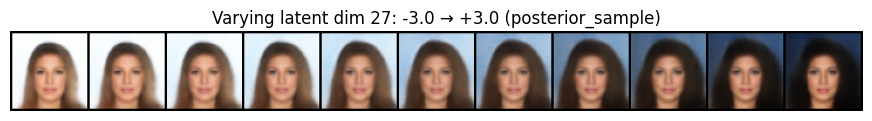

In [35]:
# Latent dimension sweep with auto-dim selection and flexible anchor
import os
import torch
from torchvision.utils import make_grid, save_image
import numpy as np

# Ensure output dir
SWEEP_DIR = 'latent_sweeps'
os.makedirs(SWEEP_DIR, exist_ok=True)

model.eval()

# ---- Configuration ----
# Choose where to anchor the sweep from:
#   'posterior_mean'  -> use encoder mean on a reference image
#   'posterior_sample'-> sample z ~ N(mu, sigma^2) from the encoder
#   'prior_sample'    -> sample z ~ N(0, I) from the prior (no image needed)
anchor_type = 'posterior_sample'  # change to 'posterior_mean' or 'prior_sample'

# Reference image selection (used for posterior_* anchors)
ref_index = 0          # index into CelebA dataset; set to an integer or change to a random pick
use_random_ref = True  # if True, overrides ref_index with a random valid index

# Sweep parameters
steps = 11            # odd number so center is the base value
sweep_amp = 3.0       # absolute range: [-sweep_amp, +sweep_amp]
probe_eps = 1.5       # used to measure which dimension is most "responsive"

# ---- Build base latent z ----
if anchor_type in ('posterior_mean', 'posterior_sample'):
    assert 'dataset' in globals(), "CelebA dataset not found in this kernel (variable 'dataset')."
    if use_random_ref:
        ref_index = np.random.randint(0, len(dataset))
    x0, _ = dataset[ref_index]
    if x0.ndim == 3:
        x0 = x0.unsqueeze(0)
    x0 = x0.to(device)
    with torch.no_grad():
        mu0, logvar0 = model.encode(x0)
        sigma0 = torch.exp(0.5 * logvar0)
    if anchor_type == 'posterior_mean':
        z_base = mu0.clone()
    else:  # posterior_sample
        eps = torch.randn_like(sigma0)
        z_base = mu0 + eps * sigma0
else:
    # prior_sample
    z_base = torch.randn(1, latent_dim, device=device)

# ---- Auto-select a responsive latent dimension ----
# We measure average image change when nudging each dimension by +/- probe_eps
with torch.no_grad():
    base_img = model.decode(z_base).detach()

# Prepare a batch with plus/minus perturbations for all dimensions
D = z_base.shape[1]
z_plus = z_base.repeat(D, 1)
z_minus = z_base.repeat(D, 1)
for d in range(D):
    z_plus[d, d] += probe_eps
    z_minus[d, d] -= probe_eps

with torch.no_grad():
    imgs_plus = model.decode(z_plus).detach()
    imgs_minus = model.decode(z_minus).detach()

# Compute per-dimension responsiveness score as average MAE vs base_img
base_rep = base_img.repeat(D, 1, 1, 1)
score_plus = (imgs_plus - base_rep).abs().mean(dim=(1, 2, 3))
score_minus = (imgs_minus - base_rep).abs().mean(dim=(1, 2, 3))
scores = 0.5 * (score_plus + score_minus)

# Pick the most responsive dimension
responsive_dim = int(torch.argmax(scores).item())

# ---- Build the sweep along the chosen dimension ----
# Use absolute offsets, not scaled by sigma, so effects are visible even if sigma is tiny
deltas = torch.linspace(-sweep_amp, sweep_amp, steps, device=device)
z_sweep = z_base.repeat(steps, 1)
z_sweep[:, responsive_dim] = z_base[0, responsive_dim] + deltas

with torch.no_grad():
    imgs = model.decode(z_sweep).cpu()  # (steps, C, H, W) in [0,1]

# Save a horizontal grid
grid = make_grid(imgs, nrow=steps, padding=2)
outfile = os.path.join(
    SWEEP_DIR,
    f'latent_dim_{responsive_dim}_sweep_{anchor_type}.png'
)
save_image(grid, outfile)
print(f"Anchor: {anchor_type} | Ref idx: {ref_index if anchor_type!='prior_sample' else 'N/A'} | Chosen dim: {responsive_dim}")
print(f"Saved latent sweep to {outfile}")

# Optional inline preview
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(max(6, steps), 2.2))
    plt.axis('off')
    plt.title(f'Varying latent dim {responsive_dim}: {-sweep_amp} → +{sweep_amp} ({anchor_type})')
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.show()
except Exception:
    pass